# Metropolis Hastings

## Part A: MH Proposals and Acceptance Probabilities

> *Starting with a very general notation...*

Accepting draws from a ***proposal distribution***

$\tilde x^{(t)} \sim q(\tilde x^{(t)}|x^{(t-1)})$

according to a "coin flip"

$x^{(t)} = \left\{\begin{array}{ll}
\tilde x^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})}\right) \quad \color{gray}{\begin{array}{c}\textrm{... is the normalizing constant needed for $p$?}\\\textrm{... and what happens if $q$ is symmetric?}  \end{array}}\\
x^{(t-1)} & \text{otherwise}
\end{array}\right.$

will produce draws from $p(x^{(t)})$.

### This is a two step conditional process<br>which altogether defines a <u>transition distribution</u>

$
\begin{align*}
&\quad\, \Pr(\textrm{accept}|\textrm{proposal},\textrm{current state}) q(\textrm{proposal}|\textrm{current state})\\
&={}
\Pr(\textrm{accept}|\textrm{proposal}) p(\textrm{proposal}|\textrm{current state})\\
&={} \Pr(x^{(t)} = \tilde x^{(t)}) q(\tilde x^{(t)}|x^{(t-1)}) = p(\tilde x^{(t)}|x^{(t-1)})
\end{align*}
$

so $q(\tilde x^{(t)}|x^{(t-1)})$ is our **proposal distribuiton** but $p(\tilde x^{(t)}|x^{(t-1)})$ is our actual **transition distribuiton**

### Does it work?

Let's see for

$
\begin{align*}
p(x^{(t)}) & \rightarrow {} N(0,1)\\
q(\tilde x^{(t)}|x^{(t-1)}) & \rightarrow {} N(x^{(t-1)},\sigma)
\end{align*}
$


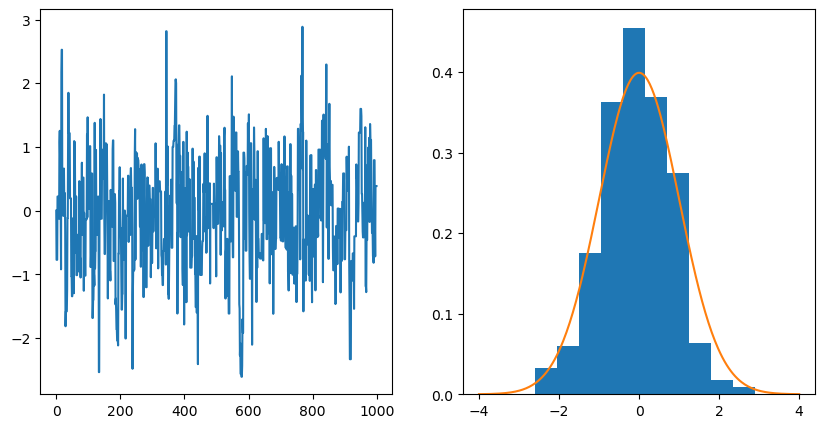

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

p_x_pdf = lambda x: stats.norm().pdf(x)
mh_tuning_parameter = 1.5
q_xt_given_xtm1 = lambda x: stats.norm(x, scale=mh_tuning_parameter)
proposal_distribution = q_xt_given_xtm1

m = 1000
x = np.zeros(m)
rejections = 0
for t in range(1,m):
    x_tilde = proposal_distribution(x[t-1]).rvs()
    acceptance_probability = min(1, p_x_pdf(x_tilde)/p_x_pdf(x[t-1]))
    if stats.uniform().rvs() < acceptance_probability:
        x[t] = x_tilde
    else:
        x[t] = x[t-1]
        rejections += 1

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x)
ax[1].hist(x, density=True)
x_support = np.linspace(-4,4,301)
ax[1].plot(x_support, p_x_pdf(x_support));

## Part B: What is MH?


### Why doesn't this work?


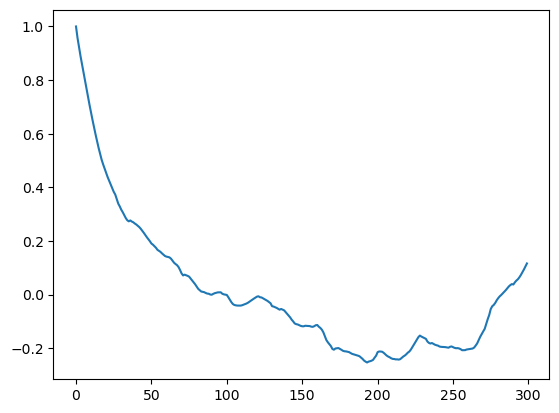

In [ ]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]

plt.plot(autocorrelations);

### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$

which is based on the relative value of $m$ between
- $\textrm{Var}\left({\sum_{t=1}^m x^{(t)}}\right) = m \sigma^2$ under i.i.d. sampling and the actual
- $\textrm{Var}\left(\sum_{t=1}^m x^{(t)}\right) = \sum_{t=1}^m \textrm{Var}\left(x^{(t)}\right) + \sum_{t \neq t'} \textrm{Cov}(x^{(t)},x^{(t')}) = m \sigma^2 + \sum_{t \neq t'} \sigma^2 \rho_{t,t'} \approx m \sigma^2+2m \sigma^2 \sum_{k=1}^m\rho_k \approx m \sigma^2+2m \sigma^2 \sum_{k=1}^\infty\rho_k $


In [ ]:
m / (1 + 2*autocorrelations[1:100].sum())

153.46195065022576

153.46195065022576

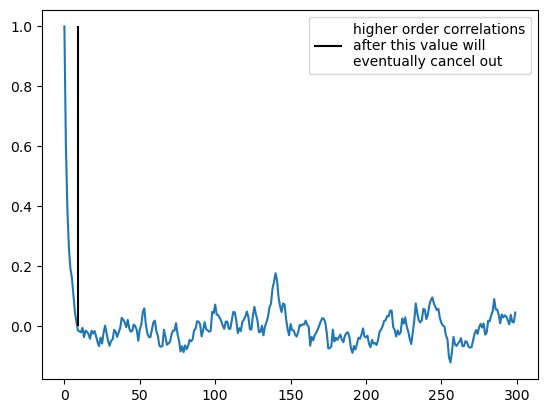

In [ ]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]

approximation_stop = (autocorrelations < 0).cumsum()
approximation_stop = approximation_stop*np.arange(K)
approximation_stop = min(approximation_stop[approximation_stop>0])

plt.plot(autocorrelations)
plt.vlines(approximation_stop, ymin=0, ymax=1, color='k',
           label='higher order correlations\nafter this value will\neventually cancel out')
plt.legend()

# effective sample size
approximation_stop, m / (1 + 2*autocorrelations[1:approximation_stop].sum())

In [ ]:
10000/14

714.2857142857143

### Rejection Rate

The **rejection rate** of the **Metropolis Hastings** algorithm given above is something else that we should keep in mind.

#### Q1: Is a high rejection rate benefiicial or detrimental for the effective sample size calculation?

#### Q2: What is the relationship between the proposal distribution and the rejection rate?

In [ ]:
rejections/m

0.418

### Why does this work?

> *Changing and hinting with the the notation to begin being suggestive about our purposes...*

If we have a **stationary distribution** $p(\theta \color{gray}{|x})$ then **transition distribution (kernel)** $p$ (not to be confused with the **Metropolis-Hastings prposal distribution** $q$!) produces a sample from this **stationary distribution** if the ***Markov chain*** it produces is ***reversible***, meaning that

$\require{cancel}
\begin{align*}
p(\theta^{(t)}|\theta^{(t-1)})p(\theta^{(t-1)}\color{gray}{|x}) & = {}  p(\theta^{(t-1)}|\theta^{(t)})p(\theta^{(t)}\color{gray}{|x})\\\\
& \textrm{But is this true if we use a Metropolis-Hastings transition distribution (kernel)?}
\\\\
p(\theta^{(t)}\color{gray}{|x}) & \overset{MH}{=} {} \frac{\alpha_{\textrm{accept prob}}^{\textrm{forward}} q(  \theta^{(t)}| \theta^{(t-1)})}{\alpha_{\textrm{accept prob}}^{\textrm{backward}} q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{\min\left(1,\frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})}\right) q( \theta^{(t)}|\theta^{(t-1)})}{\min\left(1,\frac{p( \theta^{(t-1)}\color{gray}{|x})}{p( \theta^{(t)}\color{gray}{|x})}\frac{q( \theta^{(t)}| \theta^{(t-1)})}{q( \theta^{(t-1)}| \theta^{(t)})}\right) q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\\\
& \textrm{The fractions in the "$\min$" in the numerator or denomenator are reciprocals}\\
& \textrm{thus regardless of if the numerator fraction is equal to, greater than, or less than $1$}\\\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})} \frac{q\theta^{(t)}|\theta^{(t-1)})}{q(\theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x}) \\\\
\xcancel{p( \theta^{(t)}\color{gray}{|x})} & = {} \frac{\xcancel{p(\theta^{(t)}\color{gray}{|x})}}{\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}}\frac{\cancel{q(\theta^{(t-1)}| \theta^{(t)})}}{\cancel{q( \theta^{(t)}|\theta^{(t-1)})}} \frac{\cancel{q\theta^{(t)}|\theta^{(t-1)})}}{\cancel{q(\theta^{(t-1)}|\theta^{(t)})}}\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}\\  \longrightarrow \quad 1 & ={} 1 \quad \textrm{ so the equation is true and reversibility holds}
\end{align*}$

This illustrates how the entire design and purpose of the **Metropolis-Hastings** algorithm specification (which seemingly appeared magically out of thin air) is in fact based on "reverse engineering" (if you will please excuse the pun) exactly what is needed to create a **reversible Markov Chain** (whose **stationary distribution** is the **target** of the **Metropolis-Hastings** algorithm).

## Part C: Back to Gibbs sampling

**Gibbs sampling** also creates a **reversible Markov Chain** whereby the samples, forwards or backwards, are from the same **stationary distribution** (which is the **joint posterior distribution** of the (random variable) parameters of the **full conditional (posterior) distributions**


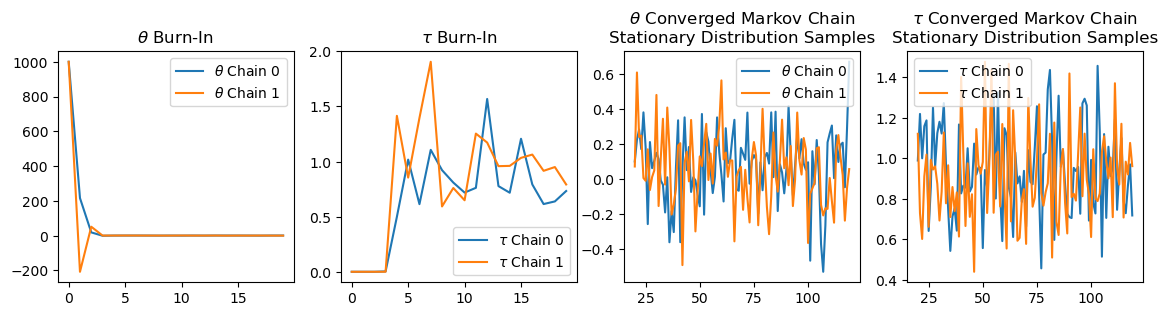

In [ ]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau[c,g] = \
        stats.gamma(a=n/2+1,
                    scale=2/((x-theta[c,g-1])**2).sum()).rvs()
        theta[c,g] = \
        stats.norm(x.mean(),
                   scale=1/np.sqrt(tau[c,g]*n)).rvs()

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

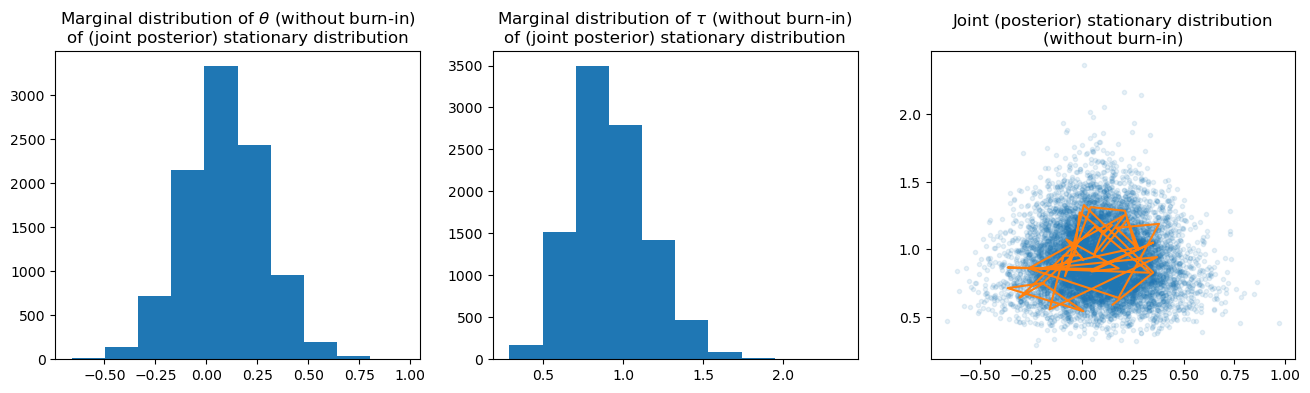

In [ ]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

## Metropolis within Gibbs

1. All **full conditional distributions** are proportional to the **joint**.
2. A **Metropolis-Hastings** step can sample from a **full conditional** by proposing a sample and accepting it according to the MH acceptance probability.
3. The target density in the MH acceptance probability appears in the numerator and denomenator so it's normalizing constants cancel and all that's needed

Accepting draws from a ***proposal distribution***

$\tilde \theta^{(t)} \sim q(\tilde \theta^{(t)}|\theta^{(t-1)})$

according to

$\require{cancel}
\theta^{(t)} = \left\{\begin{array}{ll}
\tilde \theta^{(t)} & \text{with probability } \min\bigg(1,\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})}\overset{\textrm{if symmetric}}{\cancel{\frac{q(\theta^{(t-1)}|\tilde \theta^{(t)})}{q(\tilde \theta^{(t)}|\theta^{(t-1)})}}^1}\bigg) \\
\theta^{(t-1)} & \text{otherwise}\\\\
\end{array}\right.$

will produce draws from $p(\theta^{(t)}|\tau^{(t)},\mathbf{x})$.

If we don't know the **full conditional distributions** *analytically* we can't use the *simple version* of **Gibbs sampling**. *But we do know the full conditional distributions proportionally up to their normalizing constants* and the unknown normalizing constants cancel in the target density ratios

$\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})} = \frac{p(\tilde \theta^{(t)},\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)},\tau^{(t)},\mathbf{x})} = \frac{p(\mathbf{x}|\tilde \theta^{(t)},\tau^{(t)})p(\tilde \theta^{(t)})}{p(\mathbf{x}|\theta^{(t-1)},\tau^{(t)})p(\theta^{(t-1)})}$

so all we need is the **joint distribuiton** (as a function of the parameter of the **full conditional**, here $\theta$).

And an analogous **Metropolis within Gibbs** step exists for $\tau^{(t)}$.


In [ ]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):

        # the likelihood*prior as a function of tau
        # is proportional to the full conditional of tau
        # all of which are proportion to the joint as a function of tau
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1],
                                                     scale=1/(tau_)**0.5).pdf(x))*\
                                  stats.expon(scale=1).pdf(tau_)
                                  # arbitrarily chosen tau prior
        # arbitrarily chosen MH prosal distribution for tau
        tau_propsal = stats.expon(scale=2)
        tau_tilde = tau_propsal.rvs()

        mh_calc = (tau_target(tau_tilde)/tau_target(theta[c,g-1]))*\
        (tau_propsal.pdf(theta[c,g-1])/tau_propsal.pdf(tau_tilde)
        acceptance_probability = min(1, mh_calc)
        if stats.uniform().rvs() < acceptance_probability:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]

        theta[c,g] = joint * prior_theta


## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler.
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*





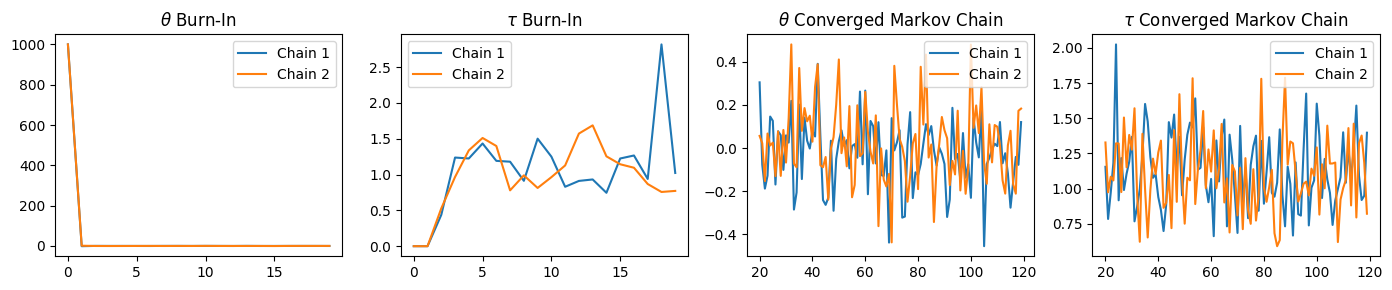

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

#-----------------------
# 1. Generate sample data
#-----------------------
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

#-----------------------
# 2. MCMC setup
#-----------------------
C, G = 2, 10000        # number of chains, number of Gibbs iterations
theta = np.zeros((C, G))
tau   = np.zeros((C, G))

# Initial values
theta[:, 0] = 1000

# Hyperparameters for the Gamma prior on tau
alpha, lambda_ = 2, 1

# Hyperparameters for the Normal prior on theta
theta_0 = 0
tau_0   = 1  # variance of the prior on theta is tau_0^2 = 1

#-----------------------
# 3. Gibbs sampling
#-----------------------
for c in range(C):
    for g in range(1, G):
        # (a) Update tau from its conditional Gamma distribution
        # shape = (n + alpha)/2
        # rate  = 0.5 * [Sum of squared residuals + lambda_]
        shape_tau = (n + alpha) / 2
        rate_tau  = 0.5 * (np.sum((x - theta[c, g-1])**2) + lambda_)
        tau[c, g] = stats.gamma(a=shape_tau, scale=1.0 / rate_tau).rvs()

        # (b) Update theta from its conditional Normal distribution
        # mean_theta   = [ (mean(x)*tau + theta_0/tau_0^2 ) / (tau*n + 1/tau_0^2 ) ]
        # var_theta    = 1 / (tau*n + 1/tau_0^2)
        mean_theta = (
            (np.mean(x) * tau[c, g]) + (theta_0 / tau_0**2)
        ) / (tau[c, g] * n + 1 / tau_0**2)
        var_theta = 1.0 / (tau[c, g] * n + 1.0 / tau_0**2)
        theta[c, g] = stats.norm(loc=mean_theta, scale=np.sqrt(var_theta)).rvs()

#-----------------------
# 4. Plotting
#-----------------------
burn = 20   # Burn-in period
demo = 120  # Just show a small segment after burn-in for demo

fig, ax = plt.subplots(1, 4, figsize=(14, 3))

# Burn-in trace of theta
ax[0].set_title(r"$\theta$ Burn-In")
for c_ in range(C):
    ax[0].plot(theta[c_, :burn], label=f"Chain {c_+1}")
ax[0].legend()

# Burn-in trace of tau
ax[1].set_title(r"$\tau$ Burn-In")
for c_ in range(C):
    ax[1].plot(tau[c_, :burn], label=f"Chain {c_+1}")
ax[1].legend()

# Post-burn-in trace of theta
ax[2].set_title(r"$\theta$ Converged Markov Chain")
for c_ in range(C):
    ax[2].plot(np.arange(burn, demo), theta[c_, burn:demo], label=f"Chain {c_+1}")
ax[2].legend()

# Post-burn-in trace of tau
ax[3].set_title(r"$\tau$ Converged Markov Chain")
for c_ in range(C):
    ax[3].plot(np.arange(burn, demo), tau[c_, burn:demo], label=f"Chain {c_+1}")
ax[3].legend()

plt.tight_layout()
plt.show()


### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*




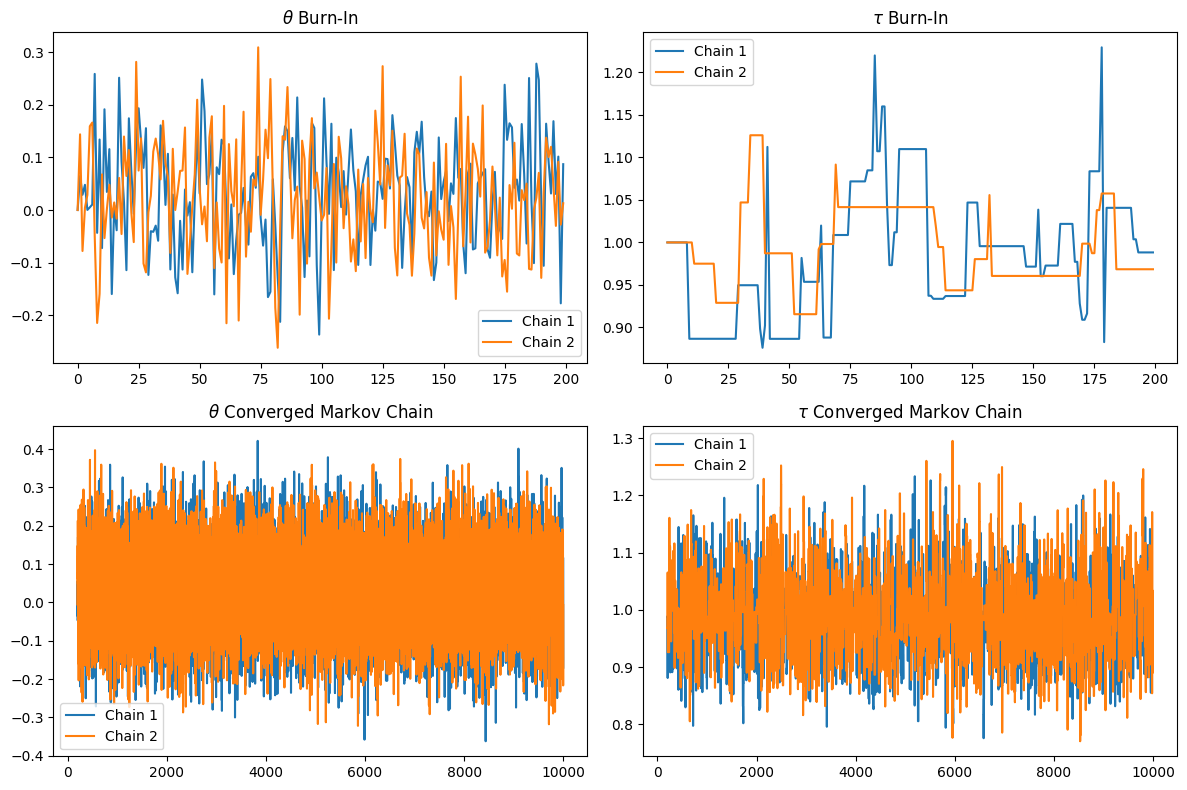

In [15]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate sample data
data = stats.norm(loc=0, scale=1).rvs(size=100)

# MCMC setup
C, G = 2, 10000  # number of chains, number of Gibbs iterations
theta = np.zeros((C, G))
tau = np.zeros((C, G))

# Initial values
theta[:, 0] = 0
tau[:, 0] = 1

# Hyperparameters for the Gamma prior on tau
alpha, lambda_ = 1, 1

# Hyperparameters for the prior on theta (use a non-normal prior)
a_theta, b_theta = 2, 5  # For example, beta distribution parameters

# Metropolis within Gibbs sampling
s = 0.5  # scale for tau proposal distribution
for c in range(C):
    for g in range(1, G):
        # Sample tau using a dependent truncated proposal distribution
        tau_t_minus_1 = tau[c, g - 1]
        proposal_tau = stats.truncnorm(
            a=(-tau_t_minus_1 / s), b=np.inf, loc=tau_t_minus_1, scale=s
        ).rvs()
        # Compute acceptance ratio for tau
        log_target_tau = (
            (alpha - 1) * np.log(proposal_tau)
            - lambda_ * proposal_tau
            - 0.5 * len(data) * np.log(2 * np.pi * proposal_tau**2)
            - np.sum((data - theta[c, g - 1]) ** 2) / (2 * proposal_tau**2)
        )
        log_target_tau_prev = (
            (alpha - 1) * np.log(tau_t_minus_1)
            - lambda_ * tau_t_minus_1
            - 0.5 * len(data) * np.log(2 * np.pi * tau_t_minus_1**2)
            - np.sum((data - theta[c, g - 1]) ** 2) / (2 * tau_t_minus_1**2)
        )
        log_acceptance_tau = log_target_tau - log_target_tau_prev
        if np.log(np.random.rand()) < log_acceptance_tau:
            tau[c, g] = proposal_tau
        else:
            tau[c, g] = tau_t_minus_1

        # Sample theta from a Beta distribution (non-normal prior)
        var_theta = 1 / (len(data) / tau[c, g] ** 2 + 1 / (a_theta * b_theta))
        mean_theta = var_theta * (
            np.sum(data) / tau[c, g] ** 2 + a_theta / b_theta
        )
        theta[c, g] = stats.norm(loc=mean_theta, scale=np.sqrt(var_theta)).rvs()

# Plotting
burn_in = 200
post_burn_in = G - burn_in

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Trace plots for theta
for c in range(C):
    axes[0, 0].plot(range(burn_in), theta[c, :burn_in], label=f"Chain {c+1}")
axes[0, 0].set_title(r"$\theta$ Burn-In")
axes[0, 0].legend()

# Trace plots for tau
for c in range(C):
    axes[0, 1].plot(range(burn_in), tau[c, :burn_in], label=f"Chain {c+1}")
axes[0, 1].set_title(r"$\tau$ Burn-In")
axes[0, 1].legend()

# Converged trace plots for theta
for c in range(C):
    axes[1, 0].plot(range(burn_in, G), theta[c, burn_in:], label=f"Chain {c+1}")
axes[1, 0].set_title(r"$\theta$ Converged Markov Chain")
axes[1, 0].legend()

# Converged trace plots for tau
for c in range(C):
    axes[1, 1].plot(range(burn_in, G), tau[c, burn_in:], label=f"Chain {c+1}")
axes[1, 1].set_title(r"$\tau$ Converged Markov Chain")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


### Q3

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$

This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain.


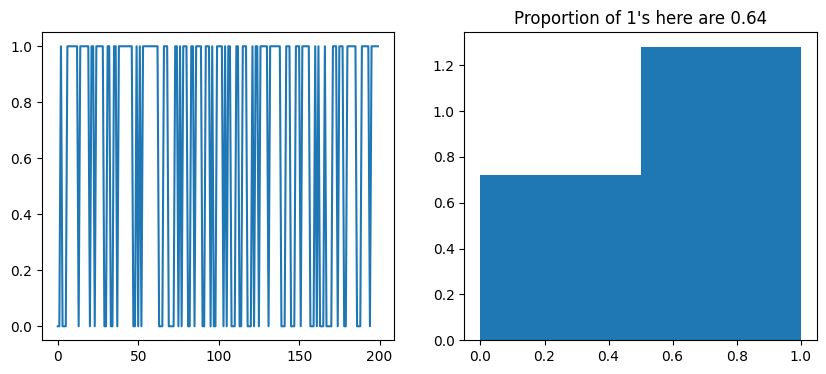

In [12]:
# Here's what it looks like if we flip coins
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]])
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])

fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

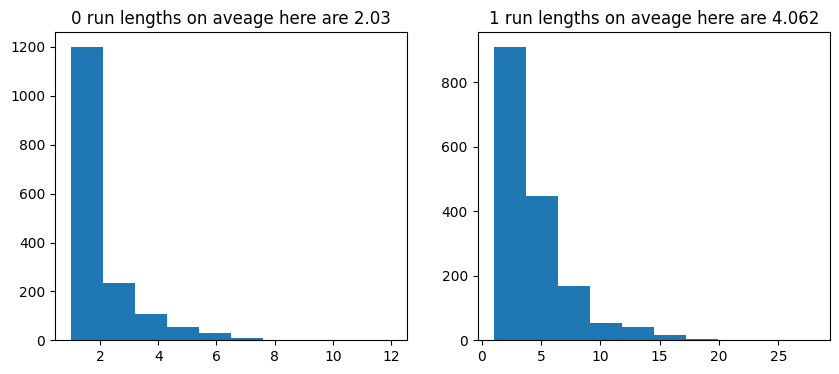

In [13]:
# Here's what it looks like if we flip coins
# with transition probabilties defind by K
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])

state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]
        run_length = 1

fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


# Q3

## Setup

- **State space**: $x \in \{0, 1\}$.

- **Proposal distribution** $q(x'(t) | x^{(t-1)})$: Regardless of the current state, the proposed state has an equal probability of $1/2$. The distribution can be expressed as:
  $$
  q(0 \mid 0) = q(1 \mid 0) = \frac{1}{2}, \quad q(0 \mid 1) = q(1 \mid 1) = \frac{1}{2}.
  $$

- **Target distribution (stationary distribution)**:
  $$
  p(0) = \frac{1}{3}, \quad p(1) = \frac{2}{3}.
  $$

## Metropolis–Hastings Acceptance Ratio

The general form of the Metropolis–Hastings acceptance ratio is:
$$
\alpha(x^{(t-1)}, x'(t)) = \min\left\{1, \frac{p(x'(t)) q(x^{(t-1)} | x'(t))}{p(x^{(t-1)}) q(x'(t) | x^{(t-1)})} \right\}.
$$

Since in this problem $q(\cdot | \cdot)$ is symmetric (uniformly distributed between 0 and 1, or 1 and 0, with equal probability of $1/2$), we have:
$$
q(x'(t) | x^{(t-1)}) = q(x^{(t-1)} | x'(t)) = \frac{1}{2}.
$$

Thus, the acceptance ratio simplifies to:
$$
\alpha(x^{(t-1)}, x'(t)) = \min\left\{1, \frac{p(x'(t))}{p(x^{(t-1)})} \right\}.
$$

Substituting the given probabilities $p(0) = \frac{1}{3}$, $p(1) = \frac{2}{3}$:
1. For $\alpha(0, 1)$:
   $$
   \alpha(0, 1) = \min\{1, p(1) / p(0)\} = \min\{1, \frac{2/3}{1/3}\} = 1.
   $$

2. For $\alpha(1, 0)$:
   $$
   \alpha(1, 0) = \min\{1, p(0) / p(1)\} = \min\{1, \frac{1/3}{2/3}\} = \frac{1}{2}.
   $$

3. When the proposed state is the same as the current state (e.g., $0 \to 0$ or $1 \to 1$), the acceptance ratio is $1$, as $p(\text{same}) / p(\text{same}) = 1$. However, the state remains unchanged, and no update occurs.

---

## Transition Probabilities

Define $K(i \to j)$ as the total probability of transitioning from state $i$ to state $j$:
1. For the current state $0$:
   - With a probability of $1/2$, propose a transition to state $1$, which is always accepted. Thus, the probability of $0 \to 1$ is $0.5$.
   - With a probability of $1/2$, propose to stay in state $0$, which is always accepted. Thus, the probability of $0 \to 0$ is $0.5$.

2. For the current state $1$:
   - With a probability of $1/2$, propose a transition to state $0$, which is accepted with a probability of $1/2$. Thus, the probability of $1 \to 0$ is $0.5 \times 0.5 = 0.25$.
   - Otherwise, stay in state $1$, with a total probability of $0.75$.

The transition matrix $K$ is:
$$
K = \begin{pmatrix}
K(0 \to 0) & K(0 \to 1) \\
K(1 \to 0) & K(1 \to 1)
\end{pmatrix}
= \begin{pmatrix}
0.5 & 0.5 \\
0.25 & 0.75
\end{pmatrix}.
$$

---

## Verifying the Stationary Distribution

Let $\pi = \left(\frac{1}{3}, \frac{2}{3}\right)$. We check if $\pi K = \pi$:
$$
\left(\frac{1}{3}, \frac{2}{3}\right)
\begin{pmatrix}
0.5 & 0.5 \\
0.25 & 0.75
\end{pmatrix}
= \left(\frac{1}{3} \times 0.5 + \frac{2}{3} \times 0.25, \frac{1}{3} \times 0.5 + \frac{2}{3} \times 0.75\right)
= \left(\frac{1}{6} + \frac{1}{6}, \frac{1}{6} + \frac{1}{2}\right)
= \left(\frac{1}{3}, \frac{2}{3}\right).
$$

Thus, $\pi$ is the stationary distribution of the Markov chain and satisfies the problem's conditions.

From an alternative perspective:
- In state $0$, the average time spent is $2$ steps (since the self-transition probability is $0.5$, with an expected waiting time of $1/(1-0.5) = 2$).
- In state $1$, the average time spent is $4$ steps (since the self-transition probability is $0.75$, with an expected waiting time of $1/(1-0.75) = 4$).
- Over the long run, the proportion of time spent in each state matches $\pi = \left(\frac{1}{3}, \frac{2}{3}\right)$.

This verifies the correctness of the stationary distribution.
